In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import graphviz
%matplotlib inline

In [2]:
df = pd.read_csv('/content/sms.csv')
df.head(10)

,Fraudolent,SMS test,ID,Date and Time
0,0,Squeeeeeze!! This is christmas hug.. If u lik ...,1EWYRBL,2017-12-02
1,0,And also I've sorta blown him off a couple tim...,ZY4PDK7,2018-03-23
2,0,Mmm thats better now i got a roast down me! i...,KLUX2C6,2016-10-29
3,0,Mm have some kanji dont eat anything heavy ok,955HXJ0,2018-04-12
4,0,So there's a ring that comes with the guys cos...,00Q6EUC,2016-08-01
5,0,Sary just need Tim in the bollox &it hurt him ...,47ON101,2016-09-18
6,0,"Love isn't a decision, it's a feeling. If we c...",UJ692M7,2018-04-18
7,0,My supervisor find 4 me one lor i thk his stud...,08XXXAW,2017-03-15
8,0,Dear good morning now only i am up,CH1OYGS,2018-02-06
9,0,I'm in chennai velachery:),QM6013N,2016-07-31


In [3]:
print("Dataset has {} rows and {} columns".format(df.shape[0], df.shape[1]))

Dataset has 5572 rows and 4 columns


In [4]:
df.isnull().sum()

Fraudolent       0
SMS test         0
ID               0
Date and Time    0
dtype: int64

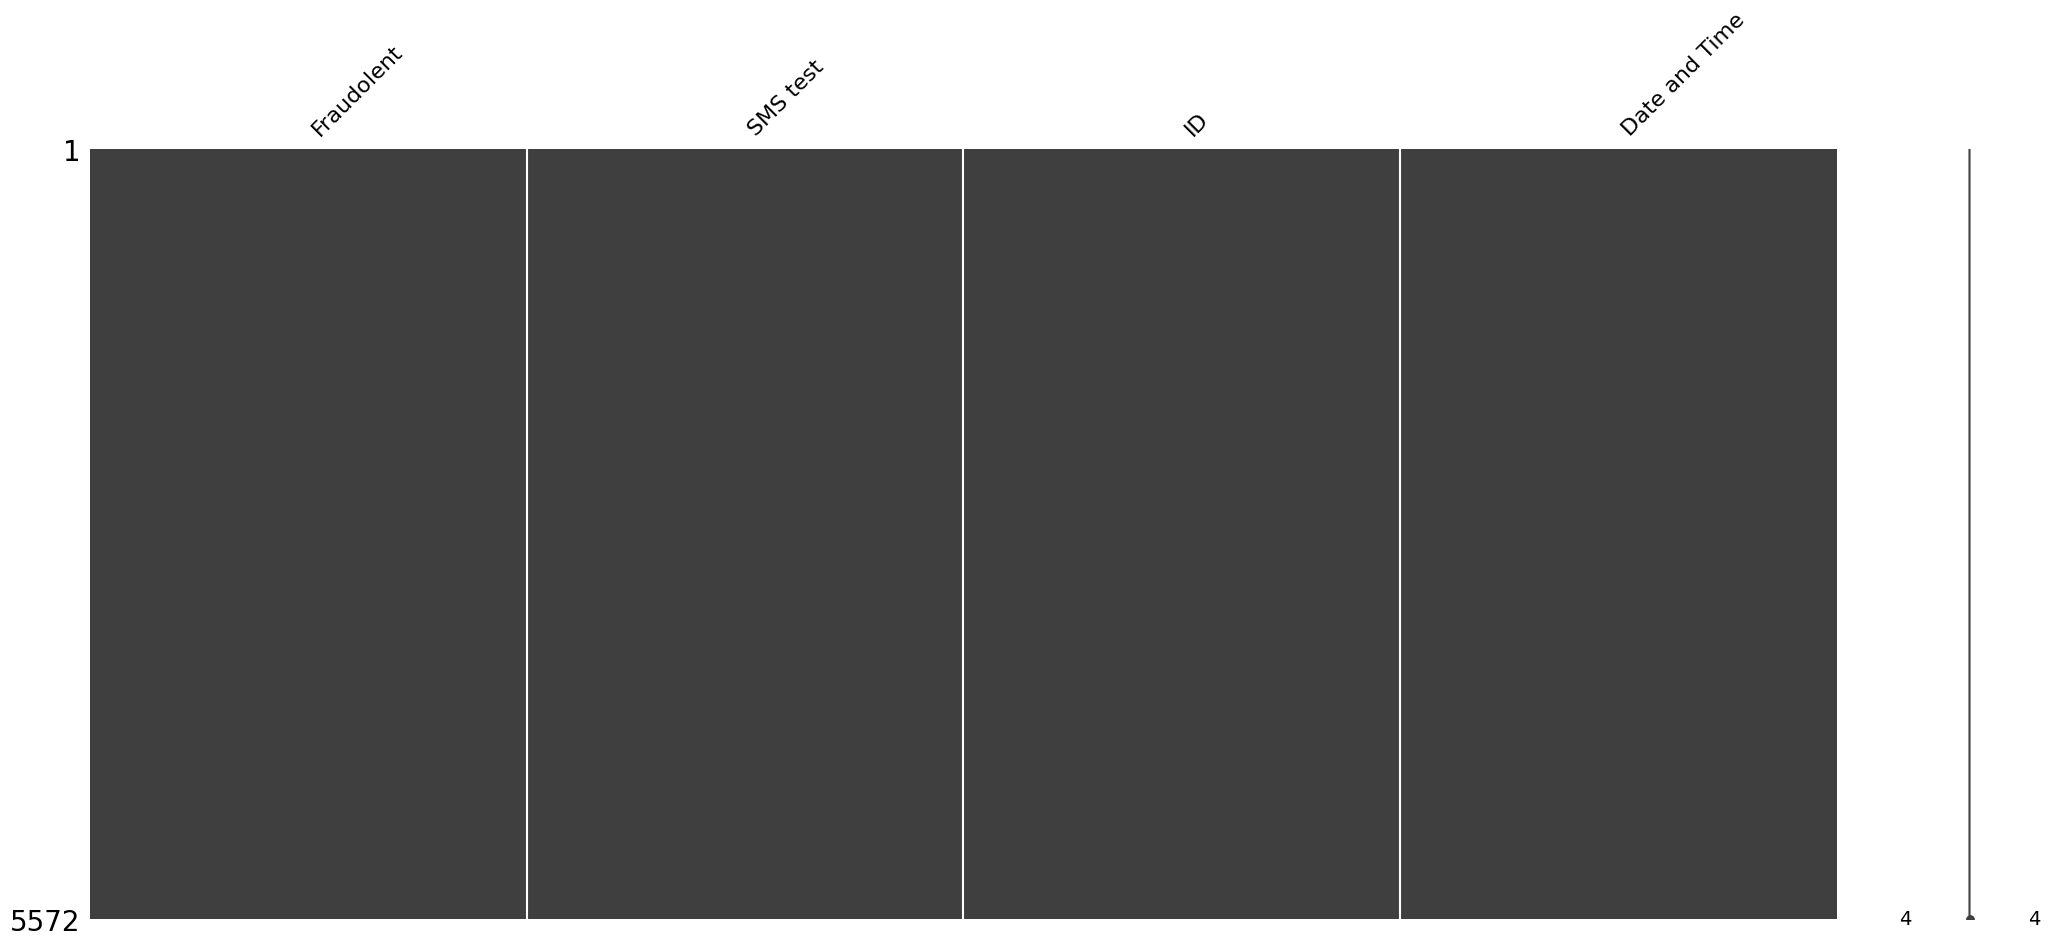

In [5]:
msno.matrix(df)
plt.show()

In [6]:
malign = df[df['Fraudolent'] == 1]
benign = df[df['Fraudolent'] == 0]
print('Fraudolent messages that has occured:',round((len(malign)/df.shape[0])*100,2),'%')
print('Fraudolent messages that has not occured:',round((len(benign)/df.shape[0])*100,2),'%')

Fraudolent messages that has occured: 13.41 %
Fraudolent messages that has not occured: 86.59 %


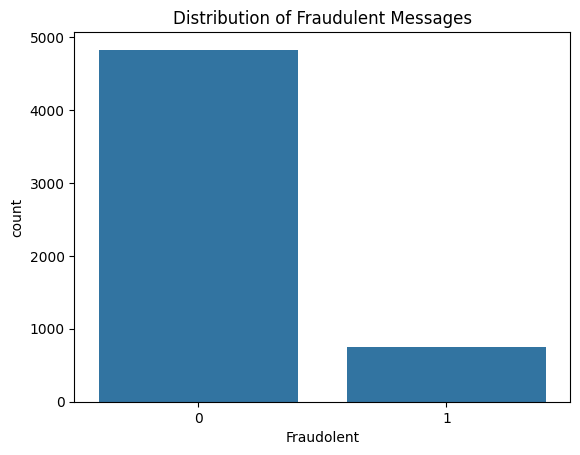

In [7]:
sns.countplot(x='Fraudolent', data=df)
plt.title('Distribution of Fraudulent Messages')
plt.show()

In [8]:
df.dtypes

Fraudolent        int64
SMS test         object
ID               object
Date and Time    object
dtype: object

In [9]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower().strip()
    return text

In [11]:
df['cleaned_sms'] = df['SMS test'].apply(clean_text)

df['tokenized_sms'] = df['cleaned_sms'].apply(word_tokenize)

stop_words = set(stopwords.words('english'))
df['tokenized_sms'] = df['tokenized_sms'].apply(lambda x: [word for word in x if word not in stop_words])

In [12]:
tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, preprocessor=None)
tfidf_matrix = tfidf.fit_transform(df['tokenized_sms'])

print(tfidf_matrix.shape)

(5572, 8494)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
df['Date and Time'] = pd.to_datetime(df['Date and Time'])

df['Year'] = df['Date and Time'].dt.year
df['Month'] = df['Date and Time'].dt.month
df['Day'] = df['Date and Time'].dt.day
df['DayOfWeek'] = df['Date and Time'].dt.dayofweek
df['Hour'] = df['Date and Time'].dt.hour


In [14]:
label_encoder = LabelEncoder()
df['ID_encoded'] = label_encoder.fit_transform(df['ID'])

df.drop(['ID', 'Date and Time'], axis=1, inplace=True)


print(df.head())
print(df.dtypes)

   Fraudolent                                           SMS test  \
0           0  Squeeeeeze!! This is christmas hug.. If u lik ...   
1           0  And also I've sorta blown him off a couple tim...   
2           0  Mmm thats better now i got a roast down me! i...   
3           0      Mm have some kanji dont eat anything heavy ok   
4           0  So there's a ring that comes with the guys cos...   

                                         cleaned_sms  \
0  squeeeeeze this is christmas hug if u lik my f...   
1  and also ive sorta blown him off a couple time...   
2  mmm thats better now i got a roast down me id ...   
3      mm have some kanji dont eat anything heavy ok   
4  so theres a ring that comes with the guys cost...   

                                       tokenized_sms  Year  Month  Day  \
0  [squeeeeeze, christmas, hug, u, lik, frndshp, ...  2017     12    2   
1  [also, ive, sorta, blown, couple, times, recen...  2018      3   23   
2  [mmm, thats, better, got, roa

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [16]:
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(df['SMS test'])
y = df['Fraudolent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
log_reg = LogisticRegression()
naive_bayes = MultinomialNB()
decision_tree = DecisionTreeClassifier()
svm = SVC()
random_forest = RandomForestClassifier()

In [18]:
models = [log_reg, naive_bayes, decision_tree, svm, random_forest]
model_names = ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'SVM', 'Random Forest']

# Training and predicting
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(f'Accuracy of {name}: {accuracy:.2f}')

Accuracy of Logistic Regression: 0.94
Accuracy of Naive Bayes: 0.96
Accuracy of Decision Tree: 0.96
Accuracy of SVM: 0.96
Accuracy of Random Forest: 0.97


In [21]:
param_dist = {
    'n_estimators': randint(100, 300),
    'max_features': ['sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}


In [23]:
rf_random_search = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(rf_random_search, param_distributions=param_dist,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print("Best parameters found:", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 256}
Best cross-validation score: 0.98


In [25]:
from sklearn.metrics import accuracy_score

best_random_model = random_search.best_estimator_
predictions = best_random_model.predict(X_test)
print("Accuracy on test set: {:.2f}".format(accuracy_score(y_test, predictions)))


Accuracy on test set: 0.97


In [26]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score


# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:\n", conf_matrix)

# Precision, Recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average='binary')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

probabilities = best_random_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, probabilities)
print(f"ROC-AUC Score: {roc_auc:.2f}")

Confusion Matrix:
 [[1418    1]
 [  41  212]]
Precision: 1.00
Recall: 0.84
F1 Score: 0.91
ROC-AUC Score: 0.99
